In [1]:
# to create a Conda environment that can be used to run the package
# conda create -n r_test -y r-essentials r-devtools

#devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




# Examples of WWA analysis

## GEV, shifts linearly with GMST & Nino3.4

- Example taken from Philippines flooding study: precip ~ GMST + Nino3.4 (model data, rather than obs)
- Fitted parameters should be essentially the same as those from extRemes

In [39]:
df <- read.csv("df_philippines-floods.csv")

# check that fitting works ok with both one and two parameters (to check that internal syntax works ok for both)
mdl1_xt <- fevd(pr, df, location.fun = ~ gmst)
mdl1_ns <- fit_ns("gev", type = "shift", data = df, varnm = "pr", covnm = c("gmst"))

mdl2_xt <- fevd(pr, df, location.fun = ~ gmst + nino)
mdl2_ns <- fit_ns("gev", type = "shift", data = df, varnm = "pr", covnm = c("gmst", "nino"))

### Visual check that fitted trend is correct

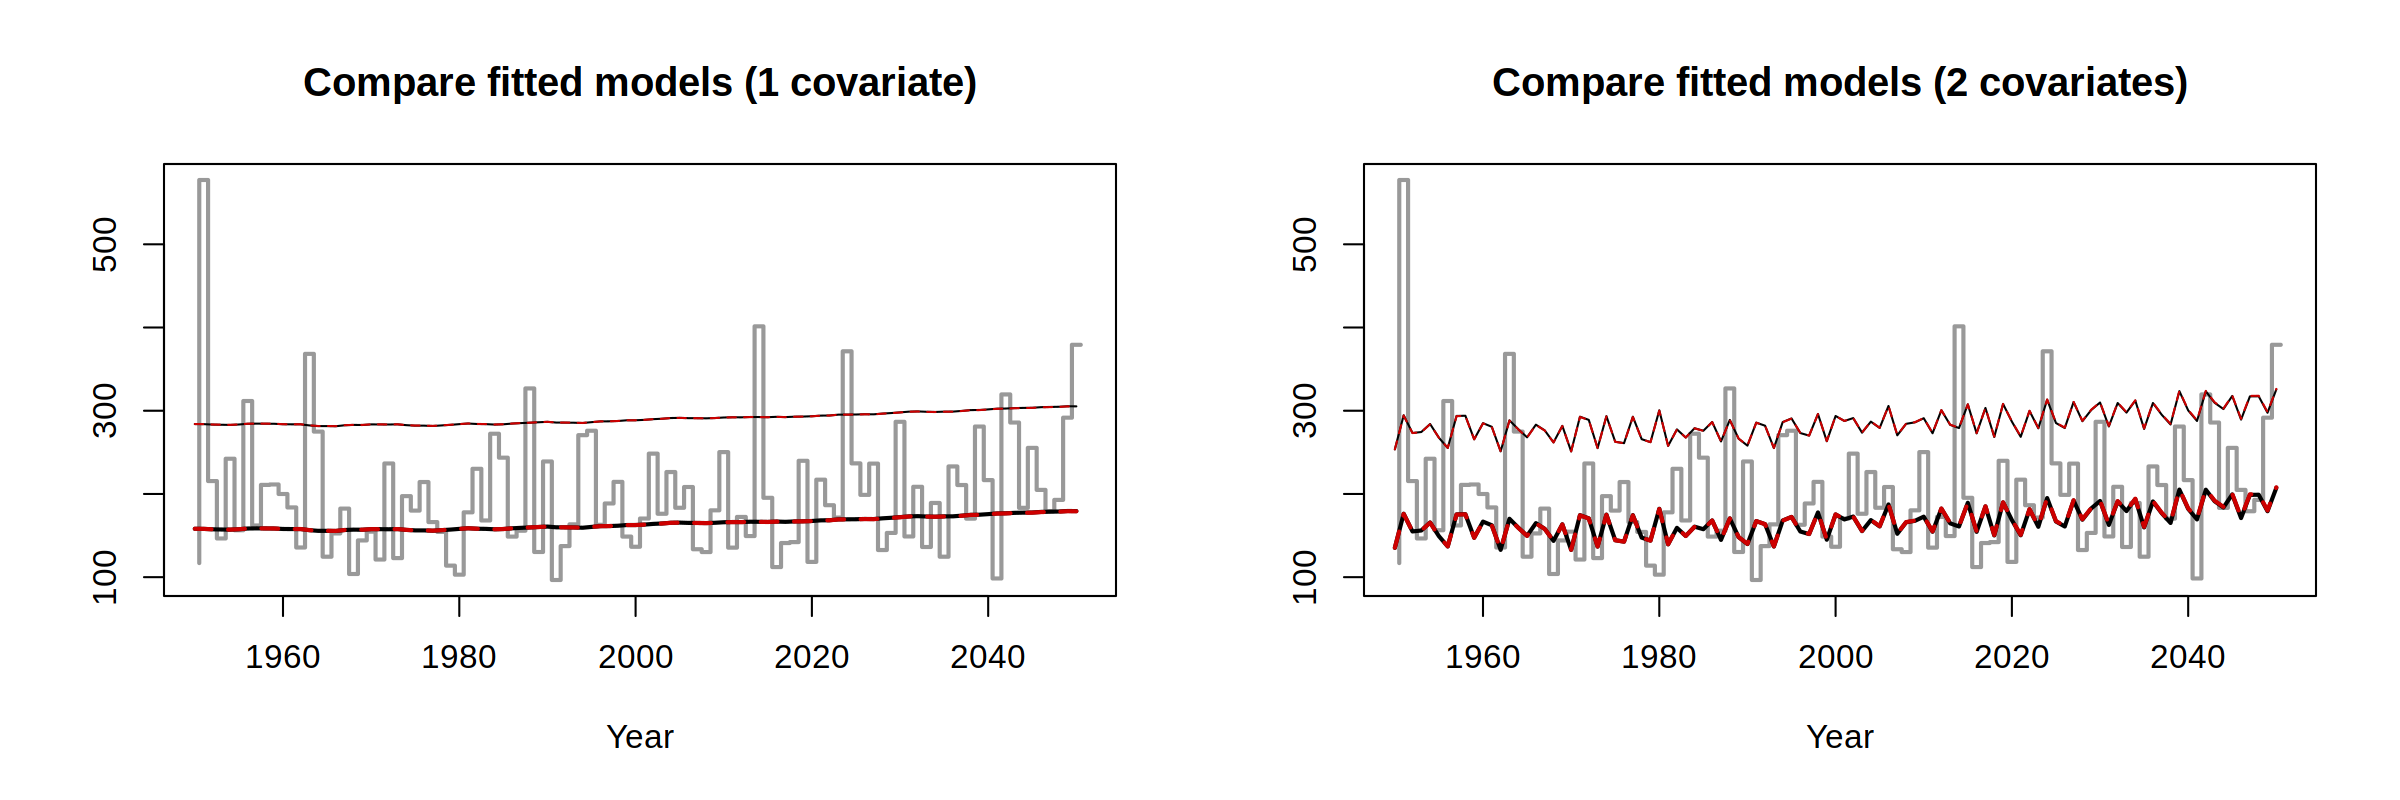

In [40]:
prep_window(c(1,3)); par(mfrow = c(1,2))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year+0.5, df$pr, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "", main = "Compare fitted models (1 covariate)")

lines(df$year, ns_pars(mdl1_ns)$loc, lwd = 2)
lines(df$year, eff_return_level(mdl1_ns, 10))

lines(df$year, findpars(mdl1_xt)$loc, lwd = 2, lty = 2, col = "red3")
lines(df$year, return.level(mdl1_xt, 10)[,1], lty = 2, col = "red3")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year+0.5, df$pr, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "", main = "Compare fitted models (2 covariates)")

lines(df$year, ns_pars(mdl2_ns)$loc, lwd = 2)
lines(df$year, eff_return_level(mdl2_ns, 10))

lines(df$year, findpars(mdl2_xt)$loc, lwd = 2, lty = 2, col = "red3")
lines(df$year, return.level(mdl2_xt, 10)[,1], lty = 2, col = "red3")


### Check plotting methods

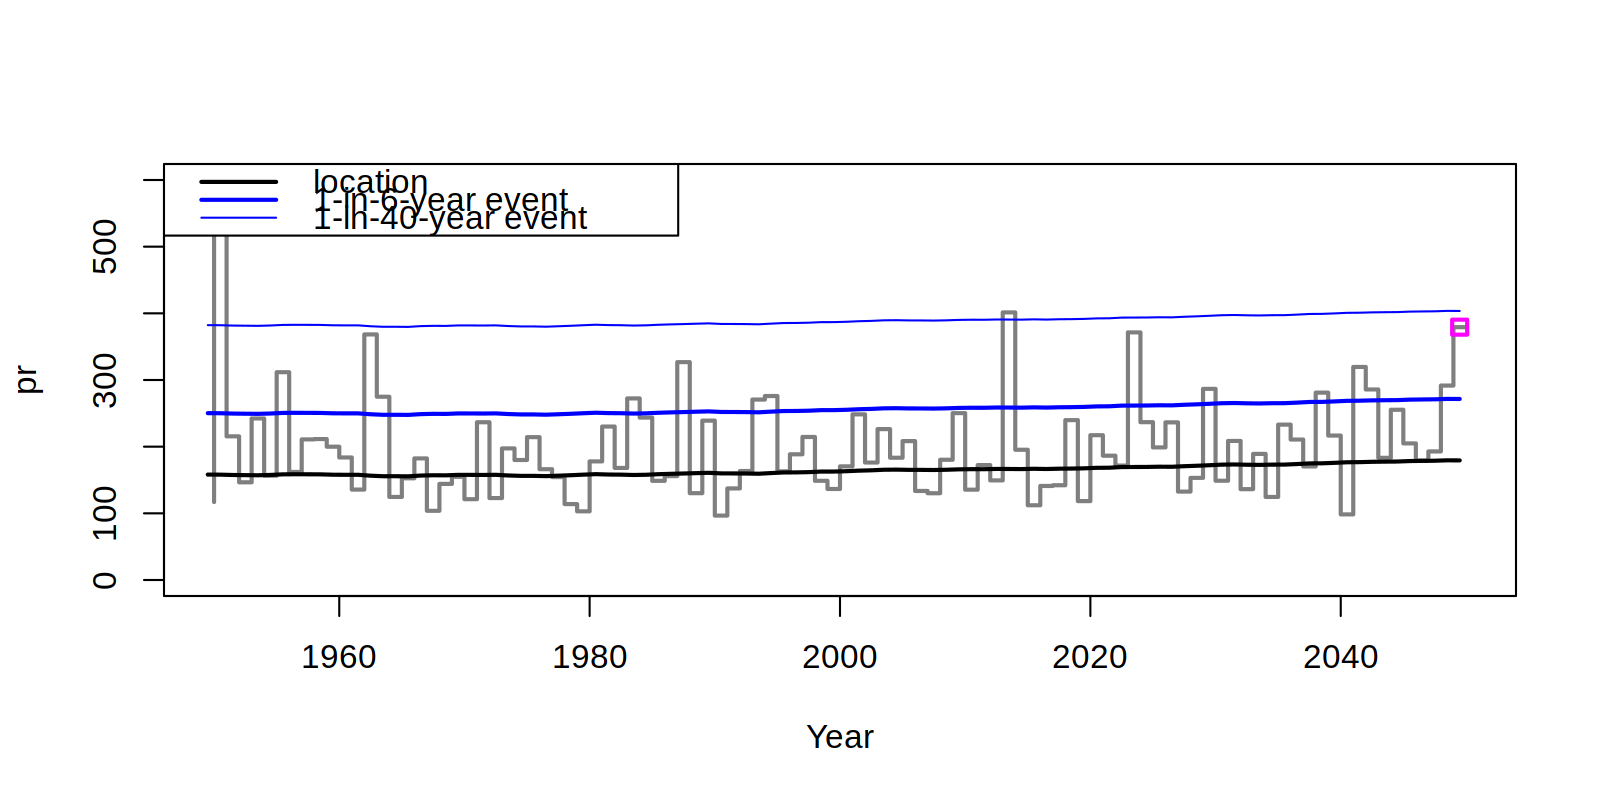

In [41]:
prep_window(c(1,2)); par(mfrow = c(1,1))
plot_trend(mdl1_ns)

In [42]:
# dataframe of covariates at which to plot confidence intervals
ci_cov <- rbind(df[df$year == 2023, c("gmst", "nino"), drop = F],
                df[df$year == 2023, c("gmst", "nino"), drop = F] - c(1.2, 0),
                df[df$year == 2023, c("gmst", "nino"), drop = F] + c(0.8, 0))

# dataframe of covariates at which to plot the trend & effective return levels
fixed_cov <- data.frame("gmst" = df$gmst, "nino" = mean(df$nino))

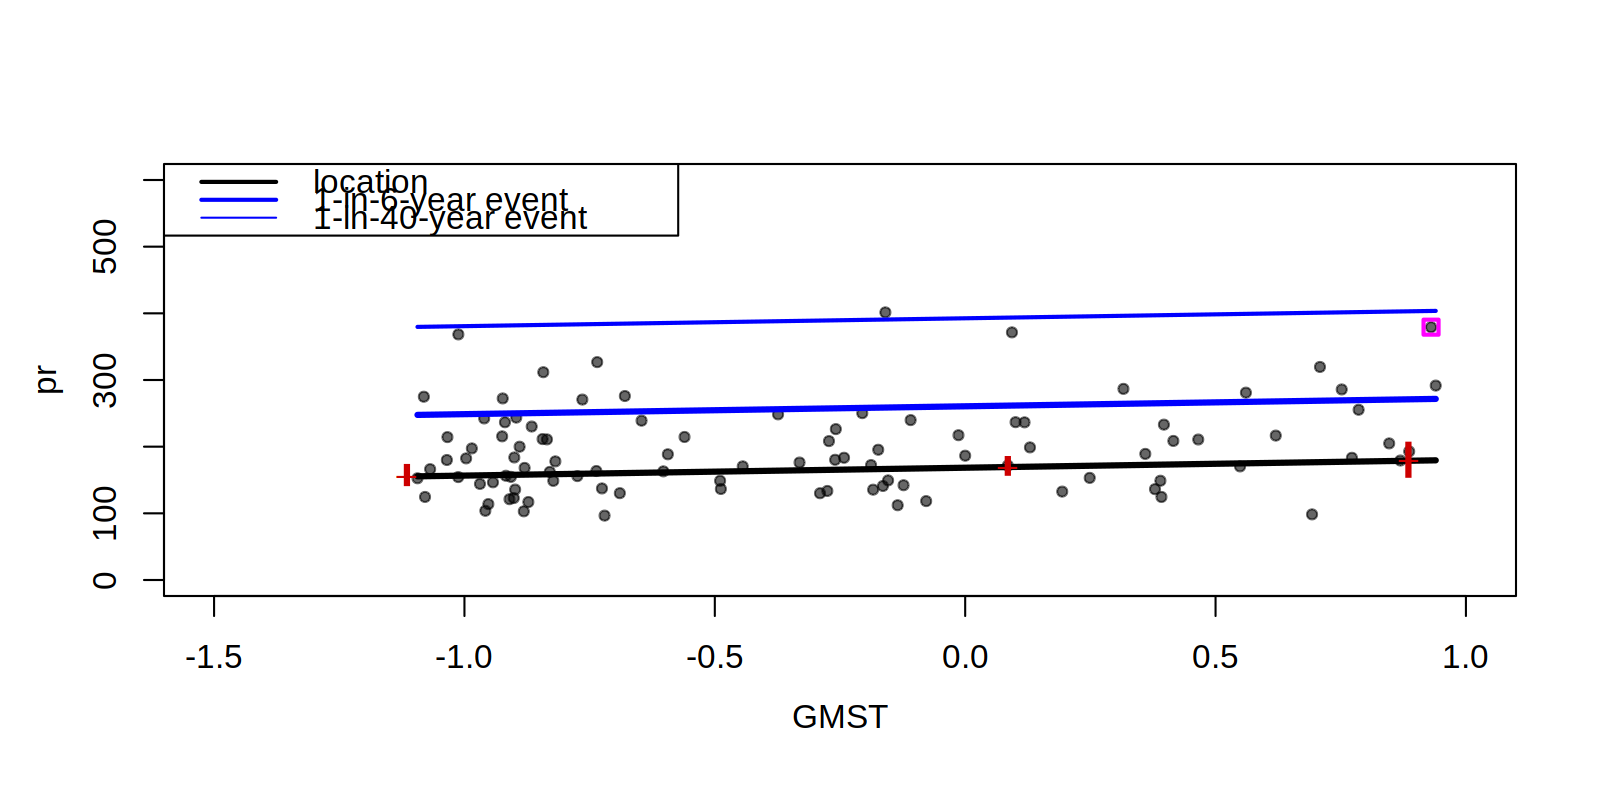

In [43]:
prep_window(c(1,2)); par(mfrow = c(1,1))
plot_covtrend(mdl1_ns, xcov = "gmst", ci_cov = ci_cov, fixed_cov = fixed_cov, nsamp = 100)

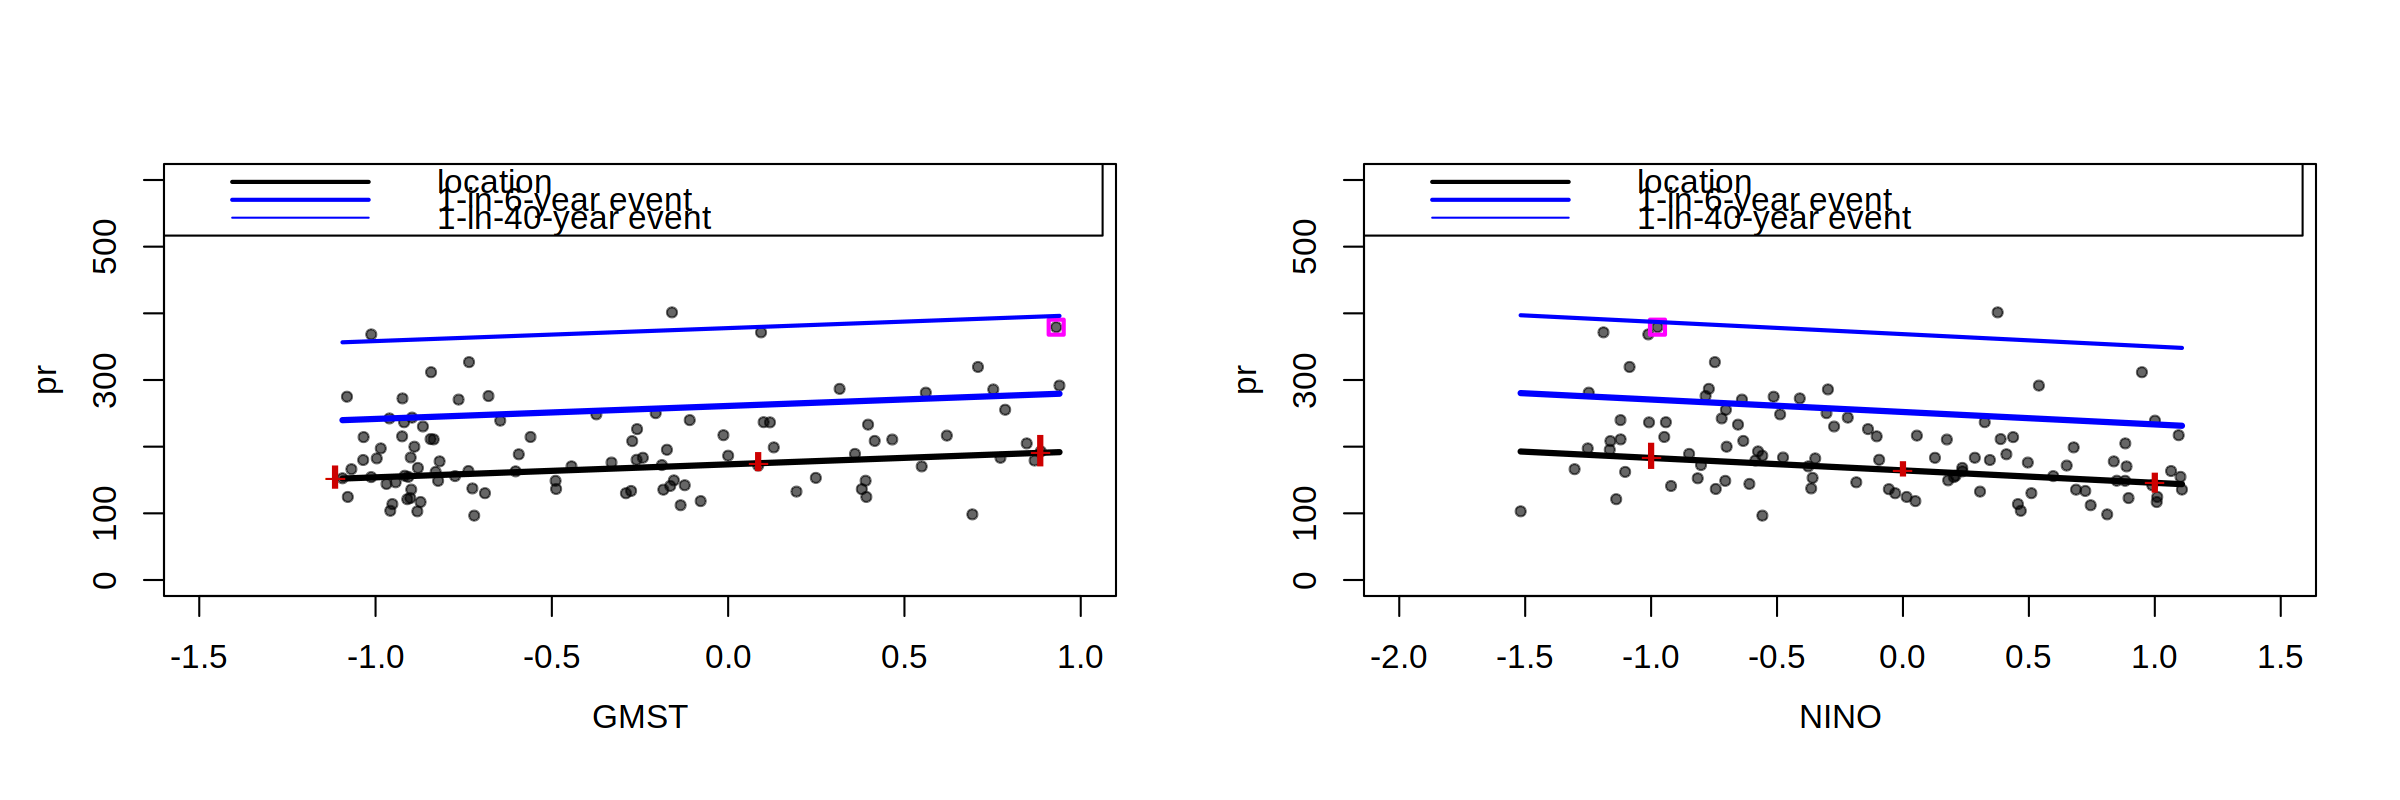

In [44]:
prep_window(c(1,3)); par(mfrow = c(1,2))

ci_cov_gmst <- data.frame(cbind("gmst" = df[df$year == 2023, "gmst"] + c(0,-1.2,0.8), "nino" = mean(df$nino)))
fixed_cov_gmst <- data.frame("gmst" = df$gmst, "nino" = mean(df$nino))

ci_cov_nino <- data.frame(cbind("gmst" = mean(df$gmst), "nino" = c(-1,0,1)))
fixed_cov_nino <- data.frame("gmst" = mean(df$gmst), "nino" = df$nino)

plot_covtrend(mdl2_ns, xcov = "gmst", ci_cov = ci_cov_gmst, fixed_cov = fixed_cov_gmst, nsamp = 100)
plot_covtrend(mdl2_ns, xcov = "nino", ci_cov = ci_cov_nino, fixed_cov = fixed_cov_nino, nsamp = 100)

[1] "cov_cf has more than one row: only first row will be used as counterfactual covariates"


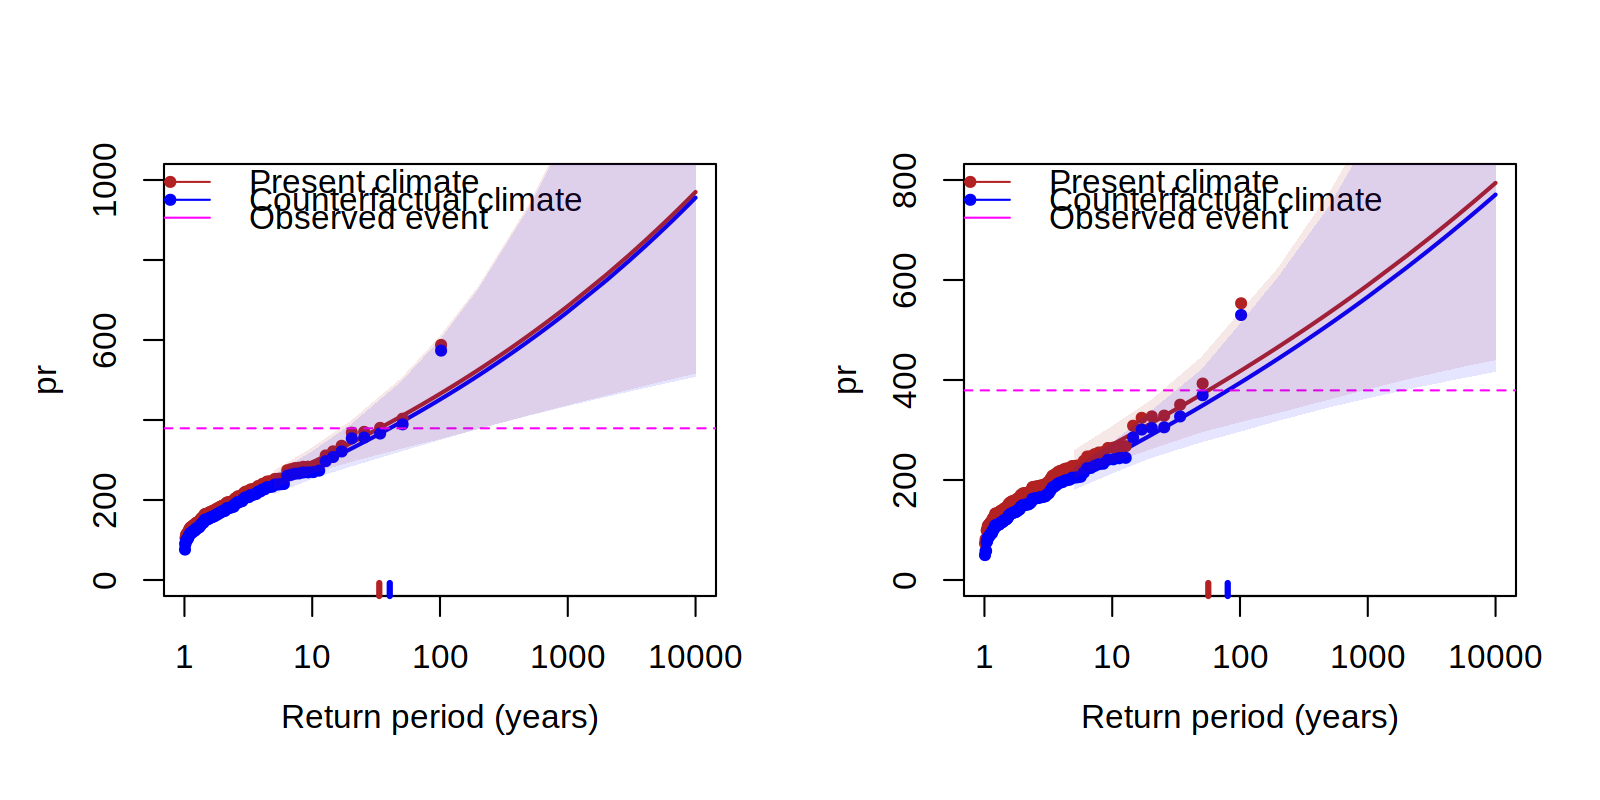

In [49]:
prep_window(c(1,2))
plot_returnlevels(mdl1_ns, cov = data.frame("gmst" = 0), cov_cf = data.frame("gmst" = -1.2), nsamp = 100)
plot_returnlevels(mdl2_ns, cov = data.frame("gmst" = 0, "nino" = 1), cov_cf = data.frame("gmst" = c(-1.2, 0.8), "nino" = c(1,1)), nsamp = 100)

### Get model results

In [55]:
# factual covariate dataframe must have one row
cov_2023 <- df[df$year == 2023,c("gmst", "nino")]

# counterfactual can have several rows
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0),
                "neut" = cov_2023 - c(0, cov_2023$nino),
                "neuthist" = cov_2023 - c(1.2, cov_2023$nino))

In [56]:
# estimate changes for current event
boot_ci(mdl2_ns, cov_2023, cov_cf, nsamp = 10)

,est,2.5%,97.5%
mu0,171.02180799,160.32930159,174.6163272
sigma0,48.23327934,42.79549648,52.5065221
alpha_gmst,19.48731079,9.63739017,26.0692339
alpha_nino,-18.65847913,-28.86159245,-12.2088796
shape,0.07552905,-0.01396346,0.1465023
disp,0.30042271,0.27774414,0.3340183
event_magnitude,379.23431396,379.23431396,379.2343140
return_period,49.85456594,31.65045754,114.4598256
PR_hist,1.42374072,1.17119402,1.9613858
dI_abs_hist,23.38477294,11.56486821,31.2830807


### Climate model results

In [131]:
# factual covariate dataframe must have one row
cov_2023 <- df[df$year == 2023,c("gmst", "nino")]

# counterfactual can have several rows
cov_hist <- rbind("pi" = cov_2023 - c(1.2, 0), "nino" = cov_2023 + c(0,1))
cov_fut <- cov_2023 + c(0.8,0)
rownames(cov_fut) <- "fut"

In [135]:
res <- cmodel_results(mdl2_ns, cov_f = cov_2023, cov_hist = cov_hist, cov_fut = cov_fut, nsamp = 50)